# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3424256/11490434 [=======>......................] - ETA: 0s

 8396800/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 15:30 - loss: 0.6918

  23/1875 [..............................] - ETA: 4s - loss: 0.5644   

  48/1875 [..............................] - ETA: 3s - loss: 0.4800

  73/1875 [>.............................] - ETA: 3s - loss: 0.4352

  99/1875 [>.............................] - ETA: 3s - loss: 0.4058

 124/1875 [>.............................] - ETA: 3s - loss: 0.3859

 150/1875 [=>............................] - ETA: 3s - loss: 0.3700

 171/1875 [=>............................] - ETA: 3s - loss: 0.3595

 200/1875 [==>...........................] - ETA: 3s - loss: 0.3473

 230/1875 [==>...........................] - ETA: 3s - loss: 0.3366

 261/1875 [===>..........................] - ETA: 3s - loss: 0.3272

 291/1875 [===>..........................] - ETA: 3s - loss: 0.3191

 317/1875 [====>.........................] - ETA: 3s - loss: 0.3129

 346/1875 [====>.........................] - ETA: 2s - loss: 0.3066

 375/1875 [=====>........................] - ETA: 2s - loss: 0.3009

 401/1875 [=====>........................] - ETA: 2s - loss: 0.2962

 427/1875 [=====>........................] - ETA: 2s - loss: 0.2918

 450/1875 [======>.......................] - ETA: 2s - loss: 0.2882

 474/1875 [======>.......................] - ETA: 2s - loss: 0.2846

 499/1875 [======>.......................] - ETA: 2s - loss: 0.2811

 524/1875 [=======>......................] - ETA: 2s - loss: 0.2778

 555/1875 [=======>......................] - ETA: 2s - loss: 0.2740

 581/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2676

 639/1875 [=========>....................] - ETA: 2s - loss: 0.2647

 668/1875 [=========>....................] - ETA: 2s - loss: 0.2619

 697/1875 [==========>...................] - ETA: 2s - loss: 0.2592

 723/1875 [==========>...................] - ETA: 2s - loss: 0.2568

 754/1875 [===========>..................] - ETA: 2s - loss: 0.2542

 785/1875 [===========>..................] - ETA: 2s - loss: 0.2516

 816/1875 [============>.................] - ETA: 1s - loss: 0.2492

 845/1875 [============>.................] - ETA: 1s - loss: 0.2470

 872/1875 [============>.................] - ETA: 1s - loss: 0.2451

 895/1875 [=============>................] - ETA: 1s - loss: 0.2435

 924/1875 [=============>................] - ETA: 1s - loss: 0.2416

 950/1875 [==============>...............] - ETA: 1s - loss: 0.2399

 981/1875 [==============>...............] - ETA: 1s - loss: 0.2379

1007/1875 [===============>..............] - ETA: 1s - loss: 0.2364

1038/1875 [===============>..............] - ETA: 1s - loss: 0.2345

1062/1875 [===============>..............] - ETA: 1s - loss: 0.2332

1089/1875 [================>.............] - ETA: 1s - loss: 0.2317

1116/1875 [================>.............] - ETA: 1s - loss: 0.2303

1146/1875 [=================>............] - ETA: 1s - loss: 0.2287

1171/1875 [=================>............] - ETA: 1s - loss: 0.2275

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1216/1875 [==================>...........] - ETA: 1s - loss: 0.2253

1236/1875 [==================>...........] - ETA: 1s - loss: 0.2243

1251/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1274/1875 [===================>..........] - ETA: 1s - loss: 0.2226

1296/1875 [===================>..........] - ETA: 1s - loss: 0.2216

1317/1875 [====================>.........] - ETA: 1s - loss: 0.2207

1339/1875 [====================>.........] - ETA: 1s - loss: 0.2198

1360/1875 [====================>.........] - ETA: 1s - loss: 0.2189

1379/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1399/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1424/1875 [=====================>........] - ETA: 0s - loss: 0.2163

1444/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1466/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1491/1875 [======================>.......] - ETA: 0s - loss: 0.2138

1518/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1544/1875 [=======================>......] - ETA: 0s - loss: 0.2119

1569/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1596/1875 [========================>.....] - ETA: 0s - loss: 0.2101

1619/1875 [========================>.....] - ETA: 0s - loss: 0.2093

1638/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1663/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1688/1875 [==========================>...] - ETA: 0s - loss: 0.2071

1718/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1750/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1781/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1809/1875 [===========================>..] - ETA: 0s - loss: 0.2034

1836/1875 [============================>.] - ETA: 0s - loss: 0.2026

1867/1875 [============================>.] - ETA: 0s - loss: 0.2018

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2015


Epoch 2/5
   1/1875 [..............................] - ETA: 6s - loss: 0.1091

  27/1875 [..............................] - ETA: 3s - loss: 0.1100

  52/1875 [..............................] - ETA: 3s - loss: 0.1101

  82/1875 [>.............................] - ETA: 3s - loss: 0.1102

 107/1875 [>.............................] - ETA: 3s - loss: 0.1104

 137/1875 [=>............................] - ETA: 3s - loss: 0.1104

 165/1875 [=>............................] - ETA: 3s - loss: 0.1104

 191/1875 [==>...........................] - ETA: 3s - loss: 0.1104

 218/1875 [==>...........................] - ETA: 3s - loss: 0.1104

 246/1875 [==>...........................] - ETA: 3s - loss: 0.1104

 270/1875 [===>..........................] - ETA: 3s - loss: 0.1103

 294/1875 [===>..........................] - ETA: 3s - loss: 0.1102

 317/1875 [====>.........................] - ETA: 2s - loss: 0.1102

 340/1875 [====>.........................] - ETA: 2s - loss: 0.1101

 363/1875 [====>.........................] - ETA: 2s - loss: 0.1100

 387/1875 [=====>........................] - ETA: 2s - loss: 0.1099

 410/1875 [=====>........................] - ETA: 2s - loss: 0.1099

 435/1875 [=====>........................] - ETA: 2s - loss: 0.1098

 459/1875 [======>.......................] - ETA: 2s - loss: 0.1097

 481/1875 [======>.......................] - ETA: 2s - loss: 0.1097

 506/1875 [=======>......................] - ETA: 2s - loss: 0.1096

 526/1875 [=======>......................] - ETA: 2s - loss: 0.1095

 546/1875 [=======>......................] - ETA: 2s - loss: 0.1095

 561/1875 [=======>......................] - ETA: 2s - loss: 0.1094

 586/1875 [========>.....................] - ETA: 2s - loss: 0.1094

 608/1875 [========>.....................] - ETA: 2s - loss: 0.1093

 632/1875 [=========>....................] - ETA: 2s - loss: 0.1092

 655/1875 [=========>....................] - ETA: 2s - loss: 0.1092

 678/1875 [=========>....................] - ETA: 2s - loss: 0.1091

 701/1875 [==========>...................] - ETA: 2s - loss: 0.1090

 725/1875 [==========>...................] - ETA: 2s - loss: 0.1090

 749/1875 [==========>...................] - ETA: 2s - loss: 0.1089

 773/1875 [===========>..................] - ETA: 2s - loss: 0.1088

 797/1875 [===========>..................] - ETA: 2s - loss: 0.1088

 821/1875 [============>.................] - ETA: 2s - loss: 0.1087

 846/1875 [============>.................] - ETA: 2s - loss: 0.1087

 869/1875 [============>.................] - ETA: 2s - loss: 0.1086

 895/1875 [=============>................] - ETA: 2s - loss: 0.1085

 917/1875 [=============>................] - ETA: 2s - loss: 0.1085

 939/1875 [==============>...............] - ETA: 1s - loss: 0.1084

 958/1875 [==============>...............] - ETA: 1s - loss: 0.1084

 979/1875 [==============>...............] - ETA: 1s - loss: 0.1083

1002/1875 [===============>..............] - ETA: 1s - loss: 0.1083

1023/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1048/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1072/1875 [================>.............] - ETA: 1s - loss: 0.1081

1092/1875 [================>.............] - ETA: 1s - loss: 0.1081

1117/1875 [================>.............] - ETA: 1s - loss: 0.1080

1137/1875 [=================>............] - ETA: 1s - loss: 0.1080

1159/1875 [=================>............] - ETA: 1s - loss: 0.1079

1177/1875 [=================>............] - ETA: 1s - loss: 0.1079

1203/1875 [==================>...........] - ETA: 1s - loss: 0.1079

1226/1875 [==================>...........] - ETA: 1s - loss: 0.1078

1249/1875 [==================>...........] - ETA: 1s - loss: 0.1078

1273/1875 [===================>..........] - ETA: 1s - loss: 0.1077

1299/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1322/1875 [====================>.........] - ETA: 1s - loss: 0.1076

1343/1875 [====================>.........] - ETA: 1s - loss: 0.1076

1365/1875 [====================>.........] - ETA: 1s - loss: 0.1075

1384/1875 [=====================>........] - ETA: 1s - loss: 0.1075

1405/1875 [=====================>........] - ETA: 1s - loss: 0.1074

1423/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1447/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1462/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1488/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1513/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1539/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1564/1875 [========================>.....] - ETA: 0s - loss: 0.1071

1585/1875 [========================>.....] - ETA: 0s - loss: 0.1071

1610/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1635/1875 [=========================>....] - ETA: 0s - loss: 0.1070

1661/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1682/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1709/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1735/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1761/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1787/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1813/1875 [============================>.] - ETA: 0s - loss: 0.1066

1839/1875 [============================>.] - ETA: 0s - loss: 0.1066

1864/1875 [============================>.] - ETA: 0s - loss: 0.1066

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1065


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1049

  24/1875 [..............................] - ETA: 4s - loss: 0.0996

  50/1875 [..............................] - ETA: 3s - loss: 0.0996

  76/1875 [>.............................] - ETA: 3s - loss: 0.0997

 101/1875 [>.............................] - ETA: 3s - loss: 0.0998

 127/1875 [=>............................] - ETA: 3s - loss: 0.0998

 153/1875 [=>............................] - ETA: 3s - loss: 0.0998

 179/1875 [=>............................] - ETA: 3s - loss: 0.0998

 205/1875 [==>...........................] - ETA: 3s - loss: 0.0998

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0997

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0997

 264/1875 [===>..........................] - ETA: 3s - loss: 0.0996

 282/1875 [===>..........................] - ETA: 3s - loss: 0.0996

 305/1875 [===>..........................] - ETA: 3s - loss: 0.0995

 326/1875 [====>.........................] - ETA: 3s - loss: 0.0995

 345/1875 [====>.........................] - ETA: 3s - loss: 0.0994

 367/1875 [====>.........................] - ETA: 3s - loss: 0.0994

 387/1875 [=====>........................] - ETA: 3s - loss: 0.0994

 405/1875 [=====>........................] - ETA: 3s - loss: 0.0993

 431/1875 [=====>........................] - ETA: 3s - loss: 0.0993

 446/1875 [======>.......................] - ETA: 3s - loss: 0.0993

 472/1875 [======>.......................] - ETA: 3s - loss: 0.0993

 497/1875 [======>.......................] - ETA: 3s - loss: 0.0992

 517/1875 [=======>......................] - ETA: 3s - loss: 0.0992

 544/1875 [=======>......................] - ETA: 3s - loss: 0.0992

 567/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0990

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0990

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0990

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0990

 736/1875 [==========>...................] - ETA: 2s - loss: 0.0989

 762/1875 [===========>..................] - ETA: 2s - loss: 0.0989

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0989

 813/1875 [============>.................] - ETA: 2s - loss: 0.0989

 838/1875 [============>.................] - ETA: 2s - loss: 0.0988

 859/1875 [============>.................] - ETA: 2s - loss: 0.0988

 884/1875 [=============>................] - ETA: 2s - loss: 0.0988

 909/1875 [=============>................] - ETA: 2s - loss: 0.0988

 934/1875 [=============>................] - ETA: 2s - loss: 0.0987

 959/1875 [==============>...............] - ETA: 2s - loss: 0.0987

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0987

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0987

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0987

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0986

1088/1875 [================>.............] - ETA: 1s - loss: 0.0986

1113/1875 [================>.............] - ETA: 1s - loss: 0.0986

1132/1875 [=================>............] - ETA: 1s - loss: 0.0986

1155/1875 [=================>............] - ETA: 1s - loss: 0.0986

1180/1875 [=================>............] - ETA: 1s - loss: 0.0986

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0985

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0985

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0985

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0985

1292/1875 [===================>..........] - ETA: 1s - loss: 0.0985

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0985

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0985

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0984

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0984

1402/1875 [=====================>........] - ETA: 1s - loss: 0.0984

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0984

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0984

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0984

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0984

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0984

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0983

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0983

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1828/1875 [============================>.] - ETA: 0s - loss: 0.0982

1850/1875 [============================>.] - ETA: 0s - loss: 0.0981

1866/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0981


Epoch 4/5
   1/1875 [..............................] - ETA: 8s - loss: 0.0927

  19/1875 [..............................] - ETA: 5s - loss: 0.0952

  38/1875 [..............................] - ETA: 5s - loss: 0.0951

  62/1875 [..............................] - ETA: 4s - loss: 0.0955

  84/1875 [>.............................] - ETA: 4s - loss: 0.0956

 110/1875 [>.............................] - ETA: 4s - loss: 0.0957

 136/1875 [=>............................] - ETA: 3s - loss: 0.0959

 162/1875 [=>............................] - ETA: 3s - loss: 0.0960

 185/1875 [=>............................] - ETA: 3s - loss: 0.0960

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 288/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0960

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0960

 365/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 386/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 409/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 433/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 455/1875 [======>.......................] - ETA: 3s - loss: 0.0961

 479/1875 [======>.......................] - ETA: 3s - loss: 0.0961

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 684/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 736/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0961

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 831/1875 [============>.................] - ETA: 2s - loss: 0.0960

 854/1875 [============>.................] - ETA: 2s - loss: 0.0960

 880/1875 [=============>................] - ETA: 2s - loss: 0.0960

 898/1875 [=============>................] - ETA: 2s - loss: 0.0960

 926/1875 [=============>................] - ETA: 2s - loss: 0.0960

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1075/1875 [================>.............] - ETA: 1s - loss: 0.0960

1107/1875 [================>.............] - ETA: 1s - loss: 0.0960

1139/1875 [=================>............] - ETA: 1s - loss: 0.0960

1165/1875 [=================>............] - ETA: 1s - loss: 0.0960

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1326/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1374/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1706/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1829/1875 [============================>.] - ETA: 0s - loss: 0.0960

1855/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0912

  28/1875 [..............................] - ETA: 3s - loss: 0.0948

  55/1875 [..............................] - ETA: 3s - loss: 0.0953

  80/1875 [>.............................] - ETA: 3s - loss: 0.0956

 104/1875 [>.............................] - ETA: 3s - loss: 0.0957

 127/1875 [=>............................] - ETA: 3s - loss: 0.0957

 152/1875 [=>............................] - ETA: 3s - loss: 0.0957

 178/1875 [=>............................] - ETA: 3s - loss: 0.0957

 205/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 231/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 255/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 302/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 323/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 346/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 367/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 389/1875 [=====>........................] - ETA: 3s - loss: 0.0957

 410/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 434/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 453/1875 [======>.......................] - ETA: 3s - loss: 0.0956

 472/1875 [======>.......................] - ETA: 3s - loss: 0.0956

 489/1875 [======>.......................] - ETA: 3s - loss: 0.0956

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 698/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 722/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 837/1875 [============>.................] - ETA: 2s - loss: 0.0954

 861/1875 [============>.................] - ETA: 2s - loss: 0.0954

 889/1875 [=============>................] - ETA: 2s - loss: 0.0954

 916/1875 [=============>................] - ETA: 2s - loss: 0.0954

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1077/1875 [================>.............] - ETA: 1s - loss: 0.0954

1100/1875 [================>.............] - ETA: 1s - loss: 0.0954

1127/1875 [=================>............] - ETA: 1s - loss: 0.0954

1153/1875 [=================>............] - ETA: 1s - loss: 0.0954

1179/1875 [=================>............] - ETA: 1s - loss: 0.0954

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1828/1875 [============================>.] - ETA: 0s - loss: 0.0953

1852/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

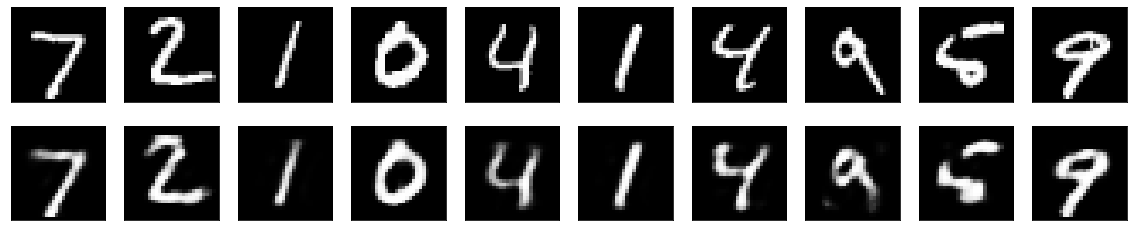

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
